<a href="https://colab.research.google.com/github/soukhind2/vgg16obj/blob/tuning_calc/Merge_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preload

Mount the google drive and load necessary packages

In [ ]:
from google.colab import drive

from pathlib import Path
import sys
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!rm -rf vgg16obj
!git clone -b tuning_calc https://github.com/soukhind2/vgg16obj
! pip install https://github.com/raghakot/keras-vis/archive/master.zip #keras vis

Cloning into 'vgg16obj'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 420 (delta 56), reused 35 (delta 12), pack-reused 307
Receiving objects: 100% (420/420), 9.18 MiB | 28.76 MiB/s, done.
Resolving deltas: 100% (233/233), done.
     | 50.1MB 85kB/s
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30857 sha256=9b98f82ca6a1804145fdc483ea681321b09aad088cb1707819e3e355b2b1f195
  Stored in directory: /tmp/pip-ephem-wheel-cache-j_6xl_3t/wheels/7e/91/e5/9fdb0f2f5fa5d9f402c6fbfaf015aadbe3dba024ede6532727
Successfully built keras-vis
  Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


In [3]:
# VGG faces model
!git clone https://github.com/rcmalli/keras-vggface.git
!pip install keras-vggface/
!pip install keras_applications
!pip install keras_preprocessing

Cloning into 'keras-vggface'...
remote: Enumerating objects: 281, done.
remote: Total 281 (delta 0), reused 0 (delta 0), pack-reused 281
Receiving objects: 100% (281/281), 6.03 MiB | 27.20 MiB/s, done.
Resolving deltas: 100% (135/135), done.
Processing ./keras-vggface
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp37-none-any.whl size=8312 sha256=6efb058bf59bc0dd79a7afbb73aede3b402ea7935e3df83a1d7aaef76cab2058
  Stored in directory: /root/.cache/pip/wheels/24/5b/69/39d5658e35d8589fc4c6c0fd1bc95b8e7ec0df4eb713277481
Successfully built keras-vggface
     |████████████████████████████████| 51kB 2.6MB/s 


Unpack the items

In [ ]:
#!unzip -q /content/drive/My\ Drive/obj/data
#!unzip -q /content/drive/My\ Drive/obj/test2
#!unzip -q /content/drive/My\ Drive/obj/sean_test
!unzip -q /content/drive/My\ Drive/obj/data_6class
!unzip -q /content/drive/My\ Drive/obj/merge


# Load libraries
Load the necessary libraries

In [4]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt
import pickle
import cv2
import seaborn as sns


from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout,Input,BatchNormalization
from keras.models import Sequential,Model
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import itertools

from vgg16obj.tools import tuning_calcs as tc
from vgg16obj.tools import gradient_calcs as gc
from vgg16obj.tools import stats as st
from vgg16obj.tools import plot_tools as pt


import tensorflow as tf
from tensorflow import math

In [5]:
# import VGG Face model
from keras_vggface.vggface import VGGFace

### Constants

In [6]:
root_directory = '/content/drive/MyDrive/NeuroScience Research/obj/'
upper_root_direcotry = '/content/drive/MyDrive/NeuroScience Research/'
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']

# Load Images

### Merged Images

In [7]:
def noisy(image):
  row,col,ch= image.shape
  mean = 0
  var = 1
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  noisy = image + gauss
  return noisy

def convertimgs(path,noise = False) :
    data = []
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            im /= 255.
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            #im = preprocess_input(im)
            if noise:
              im = noisy(im)
            data.append(im) 
    return data

(12, 80, 224, 224, 3) (12, 40, 224, 224, 3)
(12, 80, 224, 224, 3) (12, 40, 224, 224, 3)


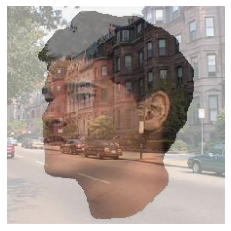

In [8]:
# Merged images load
data_train = [[]  for i in range(12)]
data_train[0] = convertimgs(upper_root_direcotry + 'merge/merge_train/Correct/Male',noise = False)  #75
data_train[1] = convertimgs(upper_root_direcotry + 'merge/merge_train/Correct/Female/',noise = False) #75
data_train[2] = convertimgs(upper_root_direcotry + 'merge/merge_train/Correct/Manmade/',noise = False) #75
data_train[3] = convertimgs(upper_root_direcotry + 'merge/merge_train/Correct/Natural/',noise = False) #75
data_train[4] = convertimgs(upper_root_direcotry + 'merge/merge_train/Correct/Powered',noise = False) #75
data_train[5] = convertimgs(upper_root_direcotry + 'merge/merge_train/Correct/Nonpowered',noise = False) #75

data_train[6] = convertimgs(upper_root_direcotry + 'merge/merge_train/Incorrect/Male',noise = False) #75
data_train[7] = convertimgs(upper_root_direcotry + 'merge/merge_train/Incorrect/Female',noise = False) #75
data_train[8] = convertimgs(upper_root_direcotry + 'merge/merge_train/Incorrect/Manmade',noise = False) #75
data_train[9] = convertimgs(upper_root_direcotry + 'merge/merge_train/Incorrect/Natural',noise = False) #75
data_train[10] = convertimgs(upper_root_direcotry + 'merge/merge_train/Incorrect/Powered',noise = False) #75
data_train[11] = convertimgs(upper_root_direcotry + 'merge/merge_train/Incorrect/Nonpowered',noise = False) #75
data_train = np.array(data_train)
 
data_test = [[]  for i in range(12)]
data_test[0] = convertimgs(upper_root_direcotry + 'merge/merge_test/Correct/Male',noise = False)  #75
data_test[1] = convertimgs(upper_root_direcotry + 'merge/merge_test/Correct/Female/',noise = False) #75
data_test[2] = convertimgs(upper_root_direcotry + 'merge/merge_test/Correct/Manmade/',noise = False) #75
data_test[3] = convertimgs(upper_root_direcotry + 'merge/merge_test/Correct/Natural/',noise = False) #75
data_test[4] = convertimgs(upper_root_direcotry + 'merge/merge_test/Correct/Powered',noise = False) #75
data_test[5] = convertimgs(upper_root_direcotry + 'merge/merge_test/Correct/Nonpowered',noise = False) #75

data_test[6] = convertimgs(upper_root_direcotry + 'merge/merge_test/Incorrect/Male',noise = False) #75
data_test[7] = convertimgs(upper_root_direcotry + 'merge/merge_test/Incorrect/Female',noise = False) #75
data_test[8] = convertimgs(upper_root_direcotry + 'merge/merge_test/Incorrect/Manmade',noise = False) #75
data_test[9] = convertimgs(upper_root_direcotry + 'merge/merge_test/Incorrect/Natural',noise = False) #75
data_test[10] = convertimgs(upper_root_direcotry + 'merge/merge_test/Incorrect/Powered',noise = False) #75
data_test[11] = convertimgs(upper_root_direcotry + 'merge/merge_test/Incorrect/Nonpowered',noise = False) #75
data_test = np.array(data_test)


print(data_train.shape,data_test.shape)

plt.imshow(data_train[0,1])
plt.axis('off')

# Regular Images load

reg_train = [[]  for i in range(12)]
reg_train[0] = convertimgs(upper_root_direcotry + 'merge/merge_reg_train/Correct/Male',noise = False)  # 75
reg_train[1] = convertimgs(upper_root_direcotry + 'merge/merge_reg_train/Correct/Female',noise = False) # 75
reg_train[2] = convertimgs(upper_root_direcotry + 'merge/merge_reg_train/Correct/Manmade',noise = False) # 75
reg_train[3] = convertimgs(upper_root_direcotry + 'merge/merge_reg_train/Correct/Natural/',noise = False) # 75
reg_train[4] = convertimgs(upper_root_direcotry + 'merge/merge_reg_train/Correct/Powered',noise = False) # 75
reg_train[5] = convertimgs(upper_root_direcotry + 'merge/merge_reg_train/Correct/Nonpowered',noise = False) # 75

reg_train[6] = convertimgs(upper_root_direcotry + 'merge/merge_reg_train/Incorrect/Male',noise = False)  # 75
reg_train[7] = convertimgs(upper_root_direcotry + 'merge/merge_reg_train/Incorrect/Female',noise = False) # 75
reg_train[8] = convertimgs(upper_root_direcotry + 'merge/merge_reg_train/Incorrect/Manmade',noise = False) # 75
reg_train[9] = convertimgs(upper_root_direcotry + 'merge/merge_reg_train/Incorrect/Natural/',noise = False) # 75
reg_train[10] = convertimgs(upper_root_direcotry + 'merge/merge_reg_train/Incorrect/Powered',noise = False) # 75
reg_train[11] = convertimgs(upper_root_direcotry + 'merge/merge_reg_train/Incorrect/Nonpowered',noise = False) # 75
reg_train = np.array(reg_train)


reg_test = [[]  for i in range(12)]
reg_test[0] = convertimgs(upper_root_direcotry + 'merge/merge_reg_test/Correct/Male',noise = False)  #75
reg_test[1] = convertimgs(upper_root_direcotry + 'merge/merge_reg_test/Correct/Female/',noise = False) #75
reg_test[2] = convertimgs(upper_root_direcotry + 'merge/merge_reg_test/Correct/Manmade/',noise = False) #75
reg_test[3] = convertimgs(upper_root_direcotry + 'merge/merge_reg_test/Correct/Natural/',noise = False) #75
reg_test[4] = convertimgs(upper_root_direcotry + 'merge/merge_reg_test/Correct/Powered',noise = False) #75
reg_test[5] = convertimgs(upper_root_direcotry + 'merge/merge_reg_test/Correct/Nonpowered',noise = False) #75

reg_test[6] = convertimgs(upper_root_direcotry + 'merge/merge_reg_test/Incorrect/Male',noise = False) #75
reg_test[7] = convertimgs(upper_root_direcotry + 'merge/merge_reg_test/Incorrect/Female',noise = False) #75
reg_test[8] = convertimgs(upper_root_direcotry + 'merge/merge_reg_test/Incorrect/Manmade',noise = False) #75
reg_test[9] = convertimgs(upper_root_direcotry + 'merge/merge_reg_test/Incorrect/Natural',noise = False) #75
reg_test[10] = convertimgs(upper_root_direcotry + 'merge/merge_reg_test/Incorrect/Powered',noise = False) #75
reg_test[11] = convertimgs(upper_root_direcotry + 'merge/merge_reg_test/Incorrect/Nonpowered',noise = False) #75
reg_test = np.array(reg_test)

print(reg_train.shape,reg_test.shape)



In [ ]:
# check the weights
import h5py
file1 = h5py.File(root_directory + '/vgg_face/vggface_weights.h5', 'r')
file2 = h5py.File(root_directory + '/vgg_face/rcmalli_vggface_tf_notop_vgg16.h5', 'r')

In [ ]:
for key in file1.keys():
    print(key)

conv1_1
conv1_2
conv2_1
conv2_2
conv3_1
conv3_2
conv3_3
conv4_1
conv4_2
conv4_3
conv5_1
conv5_2
conv5_3
fc6
fc7
fc8
flatten
input_1
pool1
pool2
pool3
pool4
pool5


In [ ]:
for key in file2.keys():
    print(key)

conv1_1
conv1_2
conv2_1
conv2_2
conv3_1
conv3_2
conv3_3
conv4_1
conv4_2
conv4_3
conv5_1
conv5_2
conv5_3
input_2
pool1
pool2
pool3
pool4
pool5


In [ ]:
group = file1['conv1_1']
print(file1['conv1_1'])

<HDF5 group "/conv1_1" (1 members)>


In [ ]:
for key2 in group.keys():
    print(key2)

# data = group[inside_key].value


conv1_1


In [ ]:
file1.close()
file2.close()

# Model
Call the base model and the top model here

In [ ]:
to_categorical([0] * ntest + [1]*ntest, dtype=int)[0]

array([1, 0])

### Model Architecture

In [32]:
# Calling VGG16 without the top FC layers with weights loaded from imagenet 
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [224,224,3])
# model = VGG16(weights=root_directory + '/vgg_face/vggface_weights.h5',
#               include_top=True,input_shape = [224,224,3],classes=2622)
# model = VGG16(weights=root_directory + '/vgg_face/rcmalli_vggface_tf_notop_vgg16.h5',
#               include_top=False,input_shape = [224,224,3],classes=2622)
# model = VGGFace(model='vgg16',
#               include_top=False,input_shape = [224,224,3])
#plot_model(model,show_shapes=True,expand_nested=True)
#model.save_weights('vgg_w',save_format='h5')

interest = 0
print('Category of interest: ', categories[interest])
train_it = np.concatenate((reg_train[interest],reg_train[interest + 6]))
test_it = np.concatenate((reg_test[interest],reg_test[interest + 6]))
print(train_it.shape,test_it.shape)

start = time.time()
features_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it) 
print(f'Test Time: {time.time() - start}')
epochs = 30

ntrain = 80
train_labels = to_categorical([0] * ntrain + [1]*ntrain)


ntest = 40
test_labels = to_categorical([0] * ntest + [1]*ntest) 
print('Test Labels Shape', test_labels.shape)
losses = 'binary_crossentropy'

# Initialize the top model with FC layers. These are the only ones to be trained
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:])) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense2'))  # to see the difference
top_model.add(Dense(2, activation='softmax',name = 'predictions'))


top_model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=[ 'accuracy', tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.AUC()])
top_model.summary()

es = EarlyStopping(monitor='loss', mode='min', verbose=1)


Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.45828771591186523
Test Time: 0.2983725070953369
Test Labels Shape (80, 2)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
top_dense1 (Dense)           (None, 4096)              102764544 
_________________________________________________________________
top_dense2 (Dense)           (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 2)                 8194      
Total params: 119,554,050
Trainable params: 119,554,050
Non-trainable params: 0
_________________________________________________________________


### Model Testing

Train the model on regular images, and then test separately on regular images
followed by testing separately for merged images

In [33]:
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
acc = np.zeros((2,6,6))
predicteds = np.zeros((2,6, 80, 2))
for imtype in range(2):
  for cat in range(6):
    print('Category of interest: ', categories[cat])
    train_it = np.concatenate((reg_train[cat],reg_train[cat + 6])) # Train on regular data
    if imtype == 0: # Regular
      test_it = np.concatenate((reg_test[cat],reg_test[cat + 6])) # Test on merged data
    else:
      test_it = np.concatenate((data_test[cat],data_test[cat + 6])) # Test on merged data
    print(train_it.shape,test_it.shape)
    start = time.time()
    train_data = model.predict(train_it)
    print(f'Train Time: {time.time() - start}')
    start = time.time()
    test_data = model.predict(test_it)
    print('Test Labels Shape 0', test_it.shape);
    print('Test Labels Shape 1', test_data.shape);
    print('Test Labels Shape 1', test_data.ravel().shape);
    print('Test Labels Shape 2', test_labels.shape);
    print(f'Test Time: {time.time() - start}')
    history = top_model.fit(x = train_data,  y = train_labels,
            epochs=epochs,
            batch_size=64,
            verbose = 1, callbacks = [es])
    out = top_model.evaluate(test_data, test_labels)
    result = top_model.predict(test_data)
    predicteds[imtype,cat] = (result)
    print('Test Labels Shape 3', result.shape)
    acc[imtype,cat] = out[1:7]
    print(out)

Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.3490009307861328
Test Labels Shape 0 (80, 224, 224, 3)
Test Labels Shape 1 (80, 7, 7, 512)
Test Labels Shape 1 (2007040,)
Test Labels Shape 2 (80, 2)
Test Time: 0.1985788345336914
Epoch 1/30
3/3 [==============================] - 1s 19ms/step - loss: 0.6967 - accuracy: 0.4840 - true_positives_4: 63.5000 - true_negatives_4: 63.5000 - false_positives_4: 64.5000 - false_negatives_4: 64.5000 - auc_4: 0.5567
Epoch 2/30
3/3 [==============================] - 0s 19ms/step - loss: 0.4486 - accuracy: 0.9199 - true_positives_4: 117.0000 - true_negatives_4: 117.0000 - false_positives_4: 11.0000 - false_negatives_4: 11.0000 - auc_4: 0.9568
Epoch 3/30
3/3 [==============================] - 0s 18ms/step - loss: 0.3325 - accuracy: 0.9262 - true_positives_4: 118.2500 - true_negatives_4: 118.2500 - false_positives_4: 9.7500 - false_negatives_4: 9.7500 - auc_4: 0.9837
Epoch 4/30
3/3 [==============================] - 0s 17ms/

In [ ]:
predicteds[1,0].shape
# predicteds[1][0]
# fpr, tpr, thersholds = roc_curve(test_labels, predicteds[1][0], pos_label=1)

(80, 2)

### Prelim result plots
Plot the average accuracy obtained for regular vs merged images

In [ ]:
print(acc)
print(acc.shape)

[[[ 0.94999999 76.         76.          4.          4.
    0.99437487]
  [ 0.91250002 73.         73.          7.          7.
    0.9367187 ]
  [ 0.97500002 78.         78.          2.          2.
    0.99625003]
  [ 0.98750001 79.         79.          1.          1.
    0.99914062]
  [ 0.78750002 63.         63.         17.         17.
    0.83562499]
  [ 0.86250001 69.         69.         11.         11.
    0.91343743]]

 [[ 0.72500002 58.         58.         22.         22.
    0.75421876]
  [ 0.67500001 54.         54.         26.         26.
    0.70109379]
  [ 0.82499999 66.         66.         14.         14.
    0.88671875]
  [ 0.63749999 51.         51.         29.         29.
    0.71585947]
  [ 0.6875     55.         55.         25.         25.
    0.73265624]
  [ 0.61250001 49.         49.         31.         31.
    0.71757811]]]
(2, 6, 6)


0.7604166666666666


Text(0, 0.5, 'Δ Accuracy')

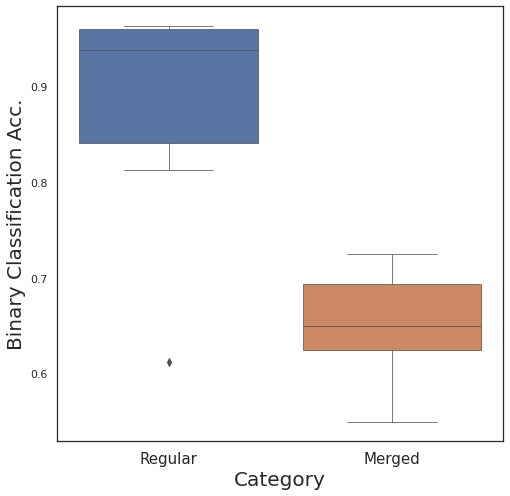

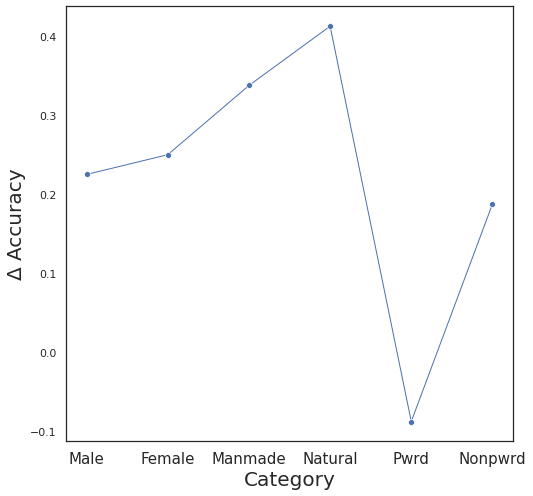

In [ ]:
diff = acc[0]-acc[1]
print(np.mean(acc))
import seaborn as sns

sns.set(style="white",rc={"lines.linewidth": 0.7})
plt.figure(figsize = (8,8))
ax = sns.boxplot(data = acc.T )
ax.set_xlabel('Category',size = 20)
ax.set_xticklabels(['Regular','Merged'],size = 15)
ax.set_ylabel('Binary Classification Acc.',size = 20)

# Cateogory wise performance difference
plt.figure(figsize = (8,8))
sns.set(style="white",rc={"lines.linewidth": 1})
ax = sns.lineplot(data = diff ,marker="o")
ax.set_xlabel('Category',size = 20)
ax.set_xticklabels(['Regular','Male','Female','Manmade','Natural','Pwrd','Nonpwrd'],size = 15)
ax.set_ylabel('\u0394 Accuracy',size = 20)



# Tuning Value Calculation

In [ ]:
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
calc_tun_activ = 1

if calc_tun_activ:
  for cat in range(6): 

    print('Category of interest: ', categories[cat])
    train_it = reg_train[cat]

    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)


    start = time.time()
    tun_activ = tc.calc_tun(train_it,activation_model,layer_names)
    print(f'Elapsed: {time.time() - start}s')

    with open(root_directory + 'tuning_values_' + str(cat), 'wb') as fp:
      pickle.dump(tun_activ, fp)



Category of interest:  Male
Elapsed: 14.491896867752075s
Category of interest:  Female
Elapsed: 14.415706157684326s
Category of interest:  Manmade
Elapsed: 14.352056503295898s
Category of interest:  Natural
Elapsed: 14.300127029418945s
Category of interest:  Powered
Elapsed: 14.38113808631897s
Category of interest:  Nonpowered
Elapsed: 14.605058193206787s


### Load tuning activities

In [ ]:
tun_activ = []
for interest in range(6): 
  with open (root_directory + 'tuning_values_' + str(interest), 'rb') as fp:
      tun_activ.extend(pickle.load(fp))
len(tun_activ)



480

In [ ]:
# load of the tunining values of vgg_face
tun_activ = []
for interest in range(6): 
  with open (root_directory + '/vgg_face' +'/tuning_values_' + str(interest), 'rb') as fp:
      tun_activ.extend(pickle.load(fp))
len(tun_activ)

480

### Calculation of tuning values for each map

In [ ]:
ncats = 6
# to fish out each category tun_activations
labels = np.array([0] * 40 + [1] * 40 + [2] * 40 + [3] * 40 + [4] * 40 + [5] * 40)
cat_tun = [[[] for j in range(len(tun_activ[0]))] for i in range(ncats)]

avg_tun_activ = tc.calc_avg(tun_activ) #average tuning activity for each map
std_tun_activ = tc.calc_std(tun_activ,avg_tun_activ) #std tuning activity for each map

for i in range(ncats):
  #Calculating average activity of each
  #feature map in response to images of respective category, 
  #with the mean activity under all image categories subtracted from it
  idx = list(np.where(labels == i))
  cat_tun[i] = tc.calc_avg([tun_activ[i] for i in idx[0]])

# Vector of tuning values for each obj cataegory
fc = [[[0 for item in subl] for subl in cat_tun[0]] for i in range(ncats)]
#fc has length of ncats x nlayers x no of maps in each layer
for cat in range(ncats):
  for layer in range(len(cat_tun[cat])):
    for map in range(len(cat_tun[cat][layer])):
      if std_tun_activ[layer][map] == 0:
        continue
      fc[cat][layer][map] = (cat_tun[cat][layer][map] - 
                                avg_tun_activ[layer][map])/std_tun_activ[layer][map]


### Tuning quality

(0.0, 50.0)

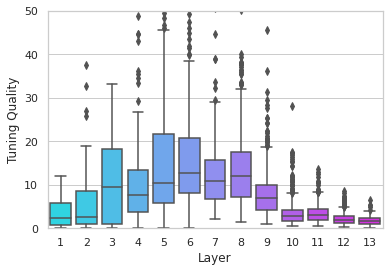

In [ ]:
tun_quality = tc.calc_tun_quality(fc)
sns.set(style="whitegrid")
ax = sns.boxplot(data = tun_quality,palette='cool')
ax.set_xlabel('Layer')
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Tuning Quality')
ax.set_ylim([0,50])

# Gradient Value Calculations

In [ ]:
calc_gradient_val = 1
if calc_gradient_val:
  d_train = data_train.reshape([960,224,224,3])
  labels = np.array([0] * 75 + [1]*75 + [2] * 75 + [3] * 75 + [4] * 75 + [5] * 75 +
                    [0] * 75 + [1]*75 + [2] * 75 + [3] * 75 + [4] * 75 + [5] * 75)
  layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
  cat_grads = [[[] for j in range(len(layer_names))] for i in range(ncats)]


  start = time.time()
  for i in range(ncats):
    idx = list(np.where(labels == i))
    cat_grads[i] = gc.calc_avg_gradcam(d_train[idx],model,top_model)
  print(f'Elapsed: {time.time() - start}s')

  with open(root_directory + 'gradient_val_cat_merged', 'wb') as fp:
      pickle.dump(cat_grads, fp)


ValueError: ignored

In [ ]:
with open (root_directory + 'gradient_val_cat_merged', 'rb') as fp:
    cat_grads = pickle.load(fp)

#cat_grads = [[[-item for item in subl] for subl in level] for level in cat_grads_posivite]
corr_all = st.calc_all_corrcoeff(fc,cat_grads)

import random

cat_grad_s = cat_grads.copy()
random.shuffle(cat_grad_s)
for cat in range(len(cat_grad_s)):
  for layer in range(len(cat_grad_s[cat])):
    random.shuffle(cat_grad_s[cat][layer])

corr_shuff = st.calc_all_corrcoeff(fc,cat_grad_s)
pt.plot_corr(corr_shuff,corr_all,figsize = (10,4))

In [ ]:
with open (root_directory + 'gradient_val_cat_merged', 'rb') as fp:
    cat_grads = pickle.load(fp)

# Attention

### Att
(This is optional. The same code is written in vgg16obj/tools/model_calcs.py called separately in the next driver chunk

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Oct 10 02:39:43 2020

@author: soukhind
"""
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.activations import relu
from keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.callbacks import EarlyStopping
from vis.utils import utils
from tensorflow.python.ops import nn
from tensorflow import math
import time
from sklearn.metrics import roc_curve,accuracy_score,precision_recall_curve,f1_score

def gen_attnmap(modifier,mask,category,bi,atype):
    """
    

    Parameters
    ----------
    modifier : list
        modifier to be used to implement attention.
    mask : ndarray
        binary vector to determine which layer to apply attention at. 
        include attention strength by multiplying to it
    category : ndarray
        cateogies .
    bi : boolean 
        bidirectionality
        True & False.
    atype: int
        1 = Multiplicative
        2 = Additive
    Returns
    -------
    tensor_attnmap : tensor
        attention map.

    """
    attnmap = []
    beta = calc_beta(avg_tun_activ)/10
  
    #conv1_1 & conv1_2
    for layer in range(2):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((224,224,64),dtype='float32') + np.tile(mapval,[224,224,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[224,224,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    #conv2_1 & conv2_2
    for layer in range(2,4):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((112,112,128),dtype='float32') + np.tile(mapval,[112,112,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[112,112,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    #conv3_1 - conv3_3
    for layer in range(4,7):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((56,56,256),dtype='float32') + np.tile(mapval,[56,56,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[56,56,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    #conv4_1 - conv4_3
    for layer in range(7,10):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((28,28,512),dtype='float32') + np.tile(mapval,[28,28,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[28,28,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    #conv5_1 - conv5_3
    for layer in range(10,13):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype ==1:
          amap = np.ones((14,14,512),dtype='float32') + np.tile(mapval,[14,14,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[14,14,1])* mask[layer]
        #amap[amap < 0] = 0
        attnmap.append(amap)
    
    tensor_attnmap = []
    for layer in range(len(attnmap)):
      tensor_attnmap.append(tf.convert_to_tensor(attnmap[layer])) 
    
    return tensor_attnmap



def avg_accuracy(data_train,train_labels,
                 data_test,test_labels,
                 modifier,
                 model,top_model,idxpath,
                 category,
                 atstrng,
                 bidir = True,
                 atype = 1):
    """
    

    Parameters
    ----------
    data_train : ndarray
        Training data.
    train_labels : categorical
        Training labels.
    data_test : ndarray
        Testing data.
    test_labels : categorical
        Testing labels.
    categories : ndarray
        Names of each category.
    modifier : list
        modifier to be used to implement attention.
    model : keras model
        base model.
    top_model : keras model
        top model.
    idxpath : string
        for internal use.
    atstrng : float32
        attention strength.
    bidir : bool, optional
        Bidirectionality. The default is True.
    atype: int
        1 = Multiplicative
        2 = Additive
    Returns
    -------
    t_acc
        Accuracy for each category at each layer.

    """
    
    epochs = 30    
    n_layers = 13
    t_acc = np.zeros((n_layers, 6))
    thr = np.zeros(n_layers)
    for li in range(n_layers):
        layermask = np.zeros(13)
        layermask[li] = 1
        tensor_attnmap = gen_attnmap(modifier,layermask*atstrng,category,bidir,atype)
        
        
        def attnrelu(x,map = tensor_attnmap,atype = atype):
            layeridx = np.load(idxpath)
            if layeridx == 13:
                layeridx = 0
            if atype == 1:
              x = nn.relu(x)
              activations = math.multiply(x,map[layeridx])
            if atype == 2:
              activations = math.add(x,map[layeridx])
              activations = nn.relu(activations)
            layeridx += 1
            np.save(idxpath,layeridx)
            return activations
    
        get_custom_objects().update({'attnrelu': Activation(attnrelu)})
    
        for layer in model.layers:
            if(hasattr(layer,'activation')):
                layer.activation = attnrelu
    
        utils.apply_modifications(model)
        model.compile()
        
        f_train = model.predict(data_train)     
    
        f_test = model.predict(data_test)
        # print(f_test)
        
        es = EarlyStopping(monitor='loss', mode='min', verbose=1)
  
        history = top_model.fit(x = f_train,  y = train_labels,
                epochs=epochs,
                batch_size=64,
                verbose = 0, callbacks = [])
    
        out = top_model.evaluate(f_test, test_labels)
        # print(out[2])
        print(out[1:7])
        t_acc[li] = out[1:7]

    return t_acc


def calc_beta(avg_act):
  beta = [0 for item in avg_act]
  for layer in range(len(avg_act)):
    for item in avg_act[layer]:
      beta[layer] += np.mean(item)
      beta = np.array(beta)
  return beta

### Driver
This is the big loop which applies attention at each layer separately as a function of different attentional strengths. 
PS. This is very heavy and requires hours to finish.


In [ ]:
#@title Multiplicative and bidirectionality corrected

# from vgg16obj.tools import model_calcs as mc
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
import gc
layeridx = 0
np.save('layeridx',layeridx)
#atstrng = 10.5 #0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10
for atstrng in np.arange(0,10,0.5): #Calling for different attn strengths
  grand_acc = [[] for i in range(6)] 
  for cat in range(6): # Iterating over 6 categories
    tf.keras.backend.clear_session()
    print('Category of interest: ', categories[cat])
    train_it = np.concatenate((reg_train[cat],reg_train[cat + 6])) # Training on regular data
    test_it = np.concatenate((data_test[cat],data_test[cat + 6])) # Testing on merged data
    print(train_it.shape,test_it.shape)
    model = VGG16(weights='imagenet',
                        include_top=False,input_shape = [224,224,3])
    # model = VGG16(weights=root_directory + '/vgg_face/vggface_weights.h5',
    #               include_top=True,input_shape = [224,224,3],classes=2622)
    model = VGG16(weights=root_directory + '/vgg_face/rcmalli_vggface_tf_notop_vgg16.h5',
                  include_top=False,input_shape = [224,224,3],classes=2622)
    # model = VGGFace(model='vgg16',
    #               include_top=False,input_shape = [224,224,3])
    top_model = Sequential()
    top_model.add(Flatten(input_shape=features_train.shape[1:])) 
    top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
    top_model.add(Dense(2, activation='sigmoid',name = 'predictions'))
    top_model.compile(optimizer= Adam(lr=1e-5),
                loss='categorical_crossentropy',
                metrics=['accuracy', tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.AUC()])
    
    # Read avg_accuracy's definition to learn about the parameters
    grand_acc[cat] = avg_accuracy(train_it,
                              train_labels,
                              test_it,
                              test_labels,
                              fc,
                              model,
                              top_model,
                              '/content/layeridx.npy',
                              cat,
                              atstrng,
                              bidir = True,
                              atype = 1 )
  grand_acc = np.array(grand_acc)
  grand_acc.reshape([6,6,13])
  # Use tun_accuracy_multi for multiplicative mode (atype = 1) and
  # use tun_accuracy_bias for bias mode (atype = 2)
  # np.save(root_directory + 'tun_accuracy_multi' + str(atstrng),grand_acc)
  # Attention results using Vggface pretrained model
  np.save(root_directory + '/vgg_face' + '/tun_accuracy_multi' + str(atstrng),grand_acc)



Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
3/3 [==============================] - 1s 7ms/step - loss: 0.6641 - accuracy: 0.7250 - true_positives: 58.0000 - true_negatives: 56.0000 - false_positives: 24.0000 - false_negatives: 22.0000 - auc: 0.7634
[0.7250000238418579, 58.0, 56.0, 24.0, 22.0, 0.7634375095367432]
3/3 [==============================] - 0s 7ms/step - loss: 0.7833 - accuracy: 0.7250 - true_positives: 58.0000 - true_negatives: 58.0000 - false_positives: 22.0000 - false_negatives: 22.0000 - auc: 0.7694
[0.7250000238418579, 58.0, 58.0, 22.0, 22.0, 0.7693749666213989]
3/3 [==============================] - 0s 8ms/step - loss: 0.8690 - accuracy: 0.7250 - true_positives: 58.0000 - true_negatives: 57.0000 - false_positives: 23.0000 - false_negatives: 22.0000 - auc: 0.7720
[0.7250000238418579, 58.0, 57.0, 23.0, 22.0, 0.7719531655311584]
3/3 [==============================] - 0s 7ms/step - loss: 0.9400 - accuracy: 0.7125 - true_positives: 57.0000 - true_negativ

In [ ]:
grand_acc[1,12,1]

44.0

In [ ]:
print(atstrng)

9.5


In [ ]:
grand_acc = []
grand_acc = np.load(root_directory + 'tun_accuracy' + str(9.5)+'.npy');
# with open (root_directory + 'tun_accuracy_new' + str(9.5)+'.npy', 'rb') as fp:
#     grand_acc.extend(pickle.load(fp))
len(grand_acc)
print(grand_acc)

[[0.77499998 0.67500001 0.63749999 0.75       0.71249998 0.69999999
  0.67500001 0.63749999 0.67500001 0.76249999 0.61250001 0.60000002
  0.58749998]
 [0.61250001 0.58749998 0.57499999 0.625      0.66250002 0.60000002
  0.52499998 0.61250001 0.5625     0.69999999 0.55000001 0.64999998
  0.5625    ]
 [0.77499998 0.625      0.82499999 0.86250001 0.77499998 0.8125
  0.78750002 0.73750001 0.85000002 0.82499999 0.85000002 0.80000001
  0.82499999]
 [0.67500001 0.76249999 0.77499998 0.71249998 0.77499998 0.73750001
  0.75       0.69999999 0.63749999 0.6875     0.69999999 0.72500002
  0.625     ]
 [0.64999998 0.625      0.6875     0.80000001 0.64999998 0.67500001
  0.66250002 0.625      0.72500002 0.60000002 0.61250001 0.64999998
  0.63749999]
 [0.64999998 0.72500002 0.61250001 0.71249998 0.66250002 0.60000002
  0.64999998 0.61250001 0.72500002 0.625      0.5625     0.64999998
  0.625     ]]


Text(0, 0.5, 'Avg. acc.')

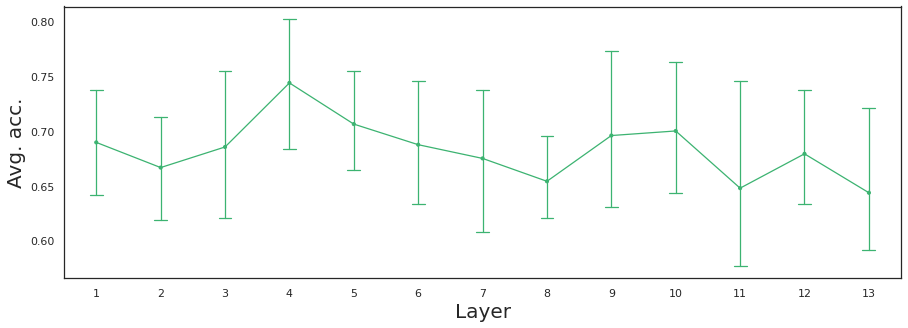

In [ ]:
import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 0.7})
plt.figure(figsize = (15,5))
ax = sns.pointplot(data = grand_acc, color = 'mediumseagreen',
                   errorwidth = 0.1 , capsize = 0.2)
ax.set_xlabel('Layer',size = 20)
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Avg. acc.',size = 20)


### Regular Accuracy
Calculate the regular accuracy so that they can be contrasted against when attention is applied.

In [ ]:
# Reinitialising the models for calculating regular accuracy
model = VGG16(weights='imagenet',
                        include_top=False,input_shape = [224,224,3])
          
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:])) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 
top_model.add(Dense(2, activation='sigmoid',name = 'predictions'))
top_model.compile(optimizer= Adam(lr=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
    
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
acc = [0]*6
for cat in range(6):
  tf.keras.backend.clear_session()

  print('Category of interest: ', categories[cat])
  train_it = np.concatenate((reg_train[cat],reg_train[cat + 6]))
  test_it = np.concatenate((data_test[cat],data_test[cat + 6]))
  print(train_it.shape,test_it.shape)


  #plot_model(model,show_shapes=True,expand_nested=True)
  #model.save_weights('vgg_w',save_format='h5')

  features_train = model.predict(train_it) 

  features_test = model.predict(test_it) 


  epochs = 30
  #train_data = np.load('features_train.npy')
  ntrain = 80
  train_data = features_train
  train_labels = to_categorical([0] * ntrain + [1]*ntrain)


  #test_data = np.load('features_test.npy')
  ntest = 40
  test_data = features_test
  test_labels = to_categorical([0] * ntest + [1]*ntest)



  es = EarlyStopping(monitor='loss', mode='min', verbose=1)

  history = top_model.fit(x = train_data,  y = train_labels,
            epochs=epochs,
            batch_size=64,
            verbose = 0, callbacks = [es])

  out = top_model.evaluate(test_data, test_labels)
  print(out)
  acc[cat] = out[1]
  #print('rounded test labels',pred)
np.mean(acc)

58892288/58889256 [==============================] - 2s 0us/step


NameError: ignored

# Plots

### Layer wise plot
This code generates the plot for performance increase as a function of attention applied at each layer separately.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.load(root_directory + 'tun_accuracy_multi0.0.npy')
x = np.expand_dims(x,0)

for i in np.arange(1,10,1):
  temp = np.load(root_directory + 'tun_accuracy_multi' + str(i) + '.0.npy')
  temp = np.expand_dims(temp,0)
  x = np.vstack((x,temp))



x = np.amax(x,0)

plt_data = np.zeros((6,13))
for i in range(6):
  for j in range(13):
    plt_data[i,j] = x[i,j] - acc[i]


import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 1})
plt.figure(figsize = (15,12))
ax = sns.pointplot(data = plt_data*100, color = 'mediumseagreen',
                   errorwidth = 0.1 , capsize = 0.2)
                   
ax.set_xlabel('Layer',size = 20)
ax.set_xticklabels(np.arange(1,14),size = 20)
plt.yticks(fontsize = 20)
plt.ylim(0,30)
plt.title('Attention by tuning curve, bias stng: 0 - 10.5',size = 15)
ax.set_ylabel('Performance Increase (%)',size = 20)

NameError: ignored

In [ ]:
# NOT REQUIRED FOR NOW
#grad_acc = plt_data
#tun_acc = plt_data

from scipy import stats
pval = np.zeros(13)

for i in range(13):
  _,pval[i] = stats.ttest_ind(tun_acc[:,i],grad_acc[:,i],equal_var=False)

pval

### Category wise plot
This code generates the plot for performance increase as a function of category and attention applied at each layer separately.

In [ ]:
gacc = np.load(root_directory + 'tun_accuracy_add0.npy')
gacc = np.expand_dims(gacc,0)

for i in np.arange(0,5,1):
  temp = np.load(root_directory + 'tun_accuracy_add' + str(i) + '.npy')
  temp = np.expand_dims(temp,0)
  gacc = np.vstack((gacc,temp))
strngs = np.arange(0.5,5,1)
'''
for i in np.arange(1,11,1):
  temp = np.load('tun_accuracy_add' + str(i) + '.npy')
  temp = np.expand_dims(temp,0)
  gacc = np.vstack((gacc,temp))
strngs = np.concatenate((strngs,np.arange(1,6,1)))'''
y = np.amax(gacc,0).T


plt_data = np.zeros((13,6))
for i in range(13):
  for j in range(6):
    plt_data[i,j] = y[i,j] - acc[j]


import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 1})
layer = 0
f,axes = plt.subplots(3,2,figsize=(15,15))
f.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Layer",size = 15)
plt.ylabel("Performance Increase (%)",size = 15)
for x in range(3):
  for y in range(2):
    axes[x,y].bar(x = np.arange(0,13),height = plt_data[:,layer]*100,color = 'mediumseagreen')
    axes[x,y].set_xticklabels(np.arange(1,14),size = 15)
    axes[x,y].set_xticks(np.arange(0,14))
    axes[x,y].set_title(categories[layer],size = 15)
    axes[x,y].set_ylim(-2,35)
    axes[x,y].set_xlim(-1,13)
    axes[x,y].hlines(y = 0,xmin= -1,xmax = 13)
    layer+=1
  

In [ ]:
acc[1,0]

array([ 0.72500002, 58.        , 58.        , 22.        , 22.        ,
        0.74234378])

### Effects of varying attention strength for layer

In [37]:
# Load the data +  '/vgg_face/'
data = [[[[] for j in range(20) ]for k in range(6)] for i in range(13)]
attentionIndex = 0;
for atstrng in np.arange(0,10,0.5): 
  temp = np.load(root_directory + 'tun_accuracy_multi' + str(atstrng)+'.npy')
  for cat in range(6):
    for layer in range(13):
      data[layer][cat][attentionIndex] = temp[cat][layer]
  attentionIndex += 1;

In [38]:
# Calculate the del_FPR, del_TPR
del_FPR = [[[ ]for k in range(6)] for i in range(13)]
del_TPR = [[[ ]for k in range(6)] for i in range(13)]
for attention in range(0, 20): 
  for cat in range(6):
    for layer in range(13):
      # 'accuracy', tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.AUC()
      # Del_To_attention_0.0
      # del_TPR[layer][cat].append((data[layer][cat][attention][1] / (data[layer][cat][attention][1]+data[layer][cat][attention][4]))-(data[layer][cat][0][1] / (data[layer][cat][0][1]+data[layer][cat][0][4])));
      # del_FPR[layer][cat].append((data[layer][cat][attention][3] / (data[layer][cat][attention][3]+data[layer][cat][attention][2]))-(data[layer][cat][0][3] / (data[layer][cat][0][3]+data[layer][cat][0][2])));
      # No_Del
      # del_TPR[layer][cat].append((data[layer][cat][attention][1] / (data[layer][cat][attention][1]+data[layer][cat][attention][4])));
      # del_FPR[layer][cat].append((data[layer][cat][attention][3] / (data[layer][cat][attention][3]+data[layer][cat][attention][2])));
      # Del_to_original
      del_TPR[layer][cat].append((data[layer][cat][attention][1] / (data[layer][cat][attention][1]+data[layer][cat][attention][4]))-(acc[1][cat][1] / (acc[1][cat][1]+acc[1][cat][4])));
      del_FPR[layer][cat].append((data[layer][cat][attention][3] / (data[layer][cat][attention][3]+data[layer][cat][attention][2]))-(acc[1][cat][3] / (acc[1][cat][3]+acc[1][cat][2])));
      

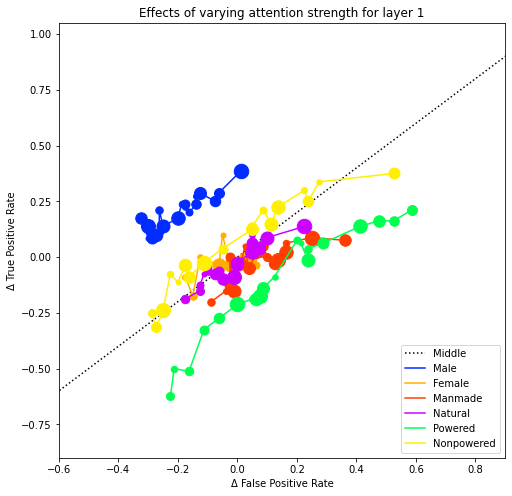

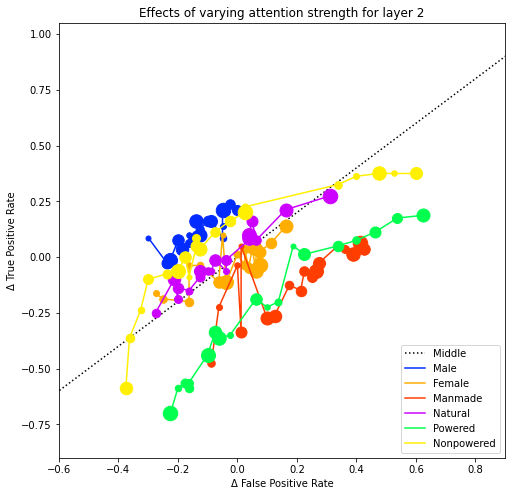

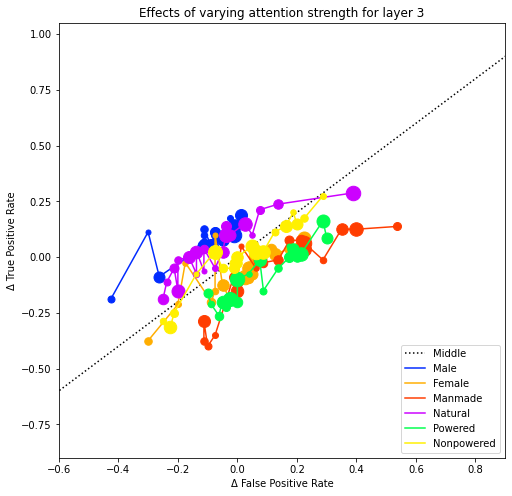

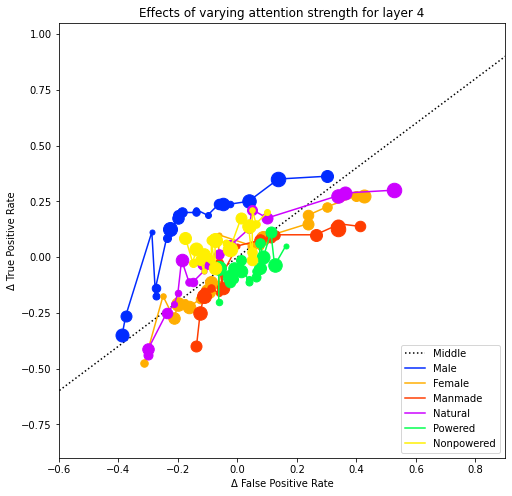

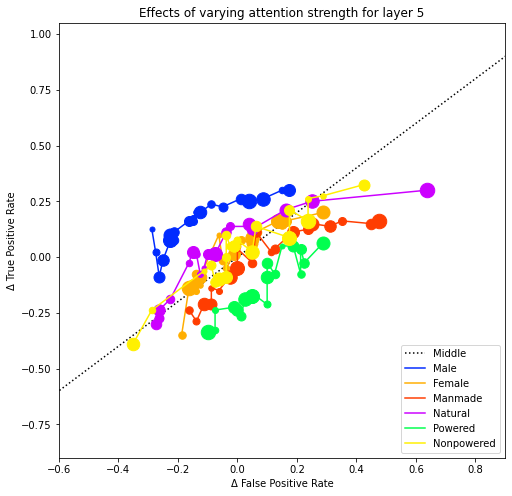

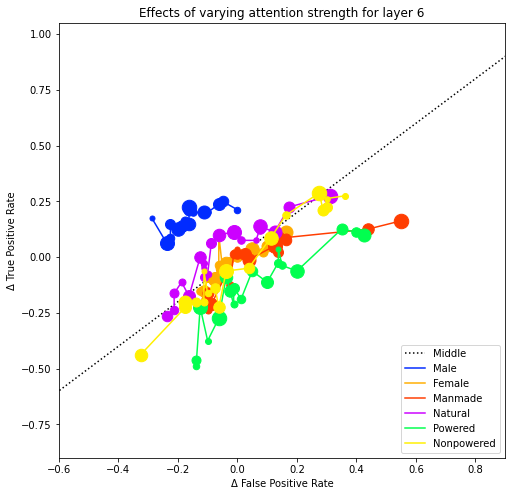

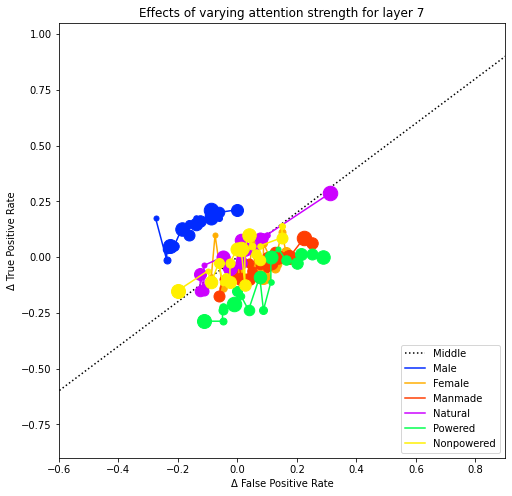

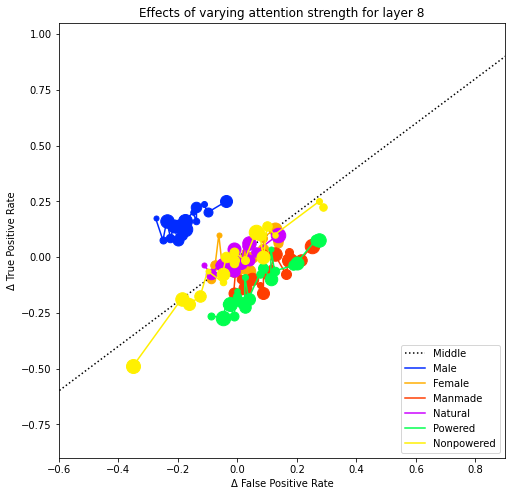

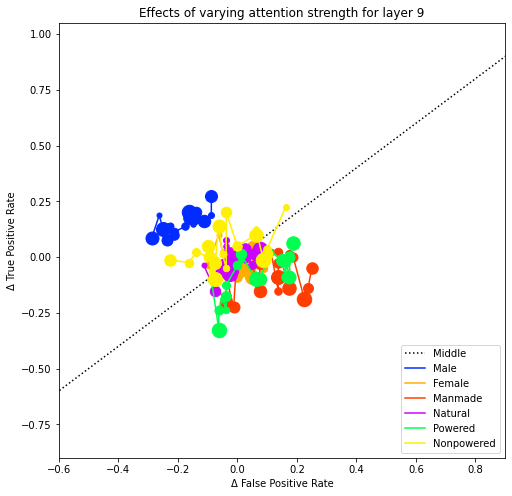

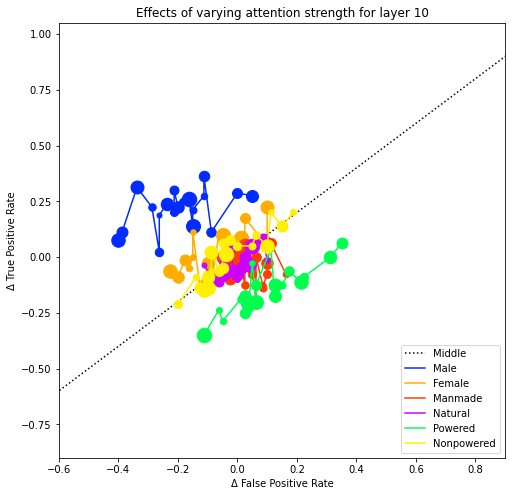

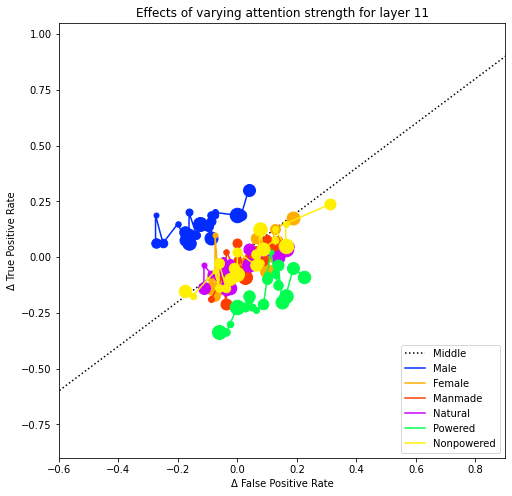

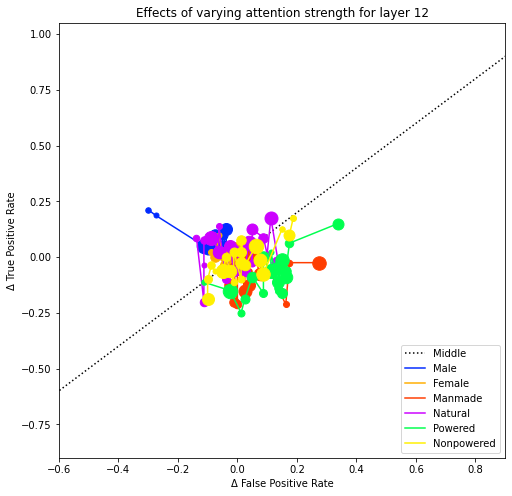

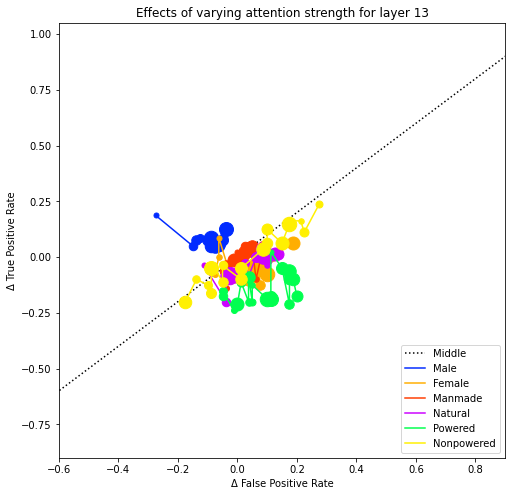

In [39]:
import matplotlib.pyplot as plt

colors = ['#012bff','#ffae01','#ff3d01','#cc01ff','#01ff4f','#fff001']

for figureNumber in range(13): # iterate over all of the layers
  plt.figure(figsize = (8,8))
  plt.xlim([-0.6, 0.9]) 
  plt.ylim([-0.9, 1.05])
  plt.xlabel('\u0394 False Positive Rate')
  plt.ylabel('\u0394 True Positive Rate') 
  plt.title('Effects of varying attention strength for layer ' + str(figureNumber + 1 ))
  plt.plot([-2,2], [-2,2], ':',label='Middle', color='black')
  for i in range(6):
    markersize = [ 5+(i/2) for i in range(20)]
    processed = list(zip(del_FPR[figureNumber][i], del_TPR[figureNumber][i], markersize))
    sortedProcessed= sorted(processed,key=lambda item: (item[0],item[1]))
    unzipped = list(zip(*sortedProcessed))
    # print(unzipped)
    # print(list(unzipped[0]))
    plt.plot(list(unzipped[0]),list(unzipped[1]), 'k',label=categories[i], color=colors[i])
    for k in range(20):
      plt.plot(sortedProcessed[k][0], sortedProcessed[k][1],'bo', markersize = sortedProcessed[k][2], color=colors[i])
  plt.legend(loc="lower right")
  # plt.savefig(root_directory + 'figures/layer_'+str(figureNumber+1)+'.png')
  # Save the figures using Vggface model +  '/vgg_face' 
  plt.savefig(root_directory  + '/figures/del_to_two_FC/layer_'+str(figureNumber+1)+'.png')
plt.show()

### ROC Curve

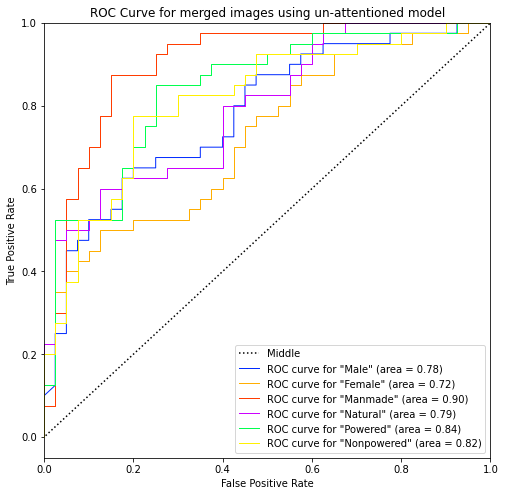

In [40]:
import matplotlib.pyplot as plt

colors = ['#012bff','#ffae01','#ff3d01','#cc01ff','#01ff4f','#fff001']
test_labels = to_categorical([0] * ntest + [1]*ntest, dtype=int)

 
plt.figure(figsize = (8,8))
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot([-2,2], [-2,2], ':',label='Middle', color='black')
for imtype in range(2):
  if imtype == 1:
    for catIndex in range(6):
      fpr,tpr,threshold = roc_curve( test_labels[:,1], predicteds[imtype, catIndex][:,1])
      roc_auc = auc(fpr,tpr)
      plt.plot(fpr, tpr, color=colors[catIndex],
              lw=1, label='ROC curve for "%s" (area = %0.2f)' % (categories[catIndex], roc_auc))
plt.xlim([0.0, 1.0])
plt.ylim([-0.05, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for merged images using un-attentioned model')
plt.legend(loc="lower right")
# plt.savefig(root_directory + '/figures/roc_curve_figure.png')
plt.savefig(root_directory + '/figures/two_FC_roc_curve_figure.png')
plt.show()